# Lab Session 3 - Federated Learning


# Part 1: Federated Learning with non-IID data

In this notebook, we study the detrimental effect of non-IID (non indepedent and identically distributed) data in the context of Federated Learning (FL).

We consider a population of 10 FL devices that federate to train a Convolutional Neural Network (CNN) to classify E-MINST images. The E-MNIST dataset comprises handwritten digits and alphabet characters.

We consider two scenarios with different degree of data heterogeneity across clients.

In the first scenario, we consider a population of devices with heterogeneous label distributions (devices have a different fraction of samples from a specific class).
In the second scenario, we also rotate the images of half of the participating devices to introduce an additional level of heterogeneity (covariate shift).

In both cases, we train the CNN and measure its generalization performance along with useful metrics to understand the effect of data heterogeneity to the training dynamics.

## Preliminaries
This section contains all preliminaries classes and methods in order to simulate an FL procedure. In particular we will:
1. Define methods to perform primitive operations such as copying model and averaging model updates.
2. Define the local training and evaluating procedure that will be performed at every FL device.
3. Define the federated learning device and server classes along with their necessary methods

In [1]:
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import AgglomerativeClustering

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

tensor([1.], device='mps:0')


### Basic operations

The following are shared methods that are used to perform basic operations on the model estimates, such as copying a source model to a target one, subtract a model to another, average model parameters and flattening model estimates into one dimensional vectors.

In [2]:
def copy(target, source):
    for name in target:
        target[name].data = source[name].data.clone()

def subtract_(target, minuend, subtrahend):
    for name in target:
        target[name].data = minuend[name].data.clone()-subtrahend[name].data.clone()

def reduce_add_average(targets, sources):
    for target in targets:
        for name in target:
            tmp = torch.mean(torch.stack([source[name].data for source in sources]), dim=0).clone()
            target[name].data += tmp

def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])

### Training operator

We now define the training operator to perform local training at each FL device.

The methods takes as input: the current model, the data loader, an optimizer and a predefined number of local epochs.

The methods updates the current model estimates, optimizing the loss function that is fed with samples from the data loader.

**EXERCISE TODO: Define a proper classification loss function between the model prediction (y_hat) and the groundtruth (y)**

In [3]:
def train_op(model, loader, optimizer, epochs=1):
    model.train()
    for ep in range(epochs):
        running_loss, samples = 0.0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat=model(x)
            ## TODO: Define the classification loss
            ## Your code here

            criterion = nn.CrossEntropyLoss() # Added

            loss = criterion(y_hat,y)
            running_loss += loss.item()*y.shape[0]
            samples += y.shape[0]
            loss.backward()
            optimizer.step()
    return running_loss / samples

### Evaluation operator
The following method evaluates the performance of the local model on a testing set.

It takes as input the current model and the test data loader. It returns the fraction of correct predictions.


In [4]:
def eval_op(model, loader):
    model.eval()               # Need to be set to evaluation mode
    samples, correct = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            _, predicted = torch.max(y_hat.data, 1)
            samples += y.shape[0]
            # Compute the number of correct samples
            correct += (predicted == y).sum().item()
    return correct/samples

## Federated Learning Client
We are now ready to define the FL client class.
This class is used to simulate an FL device and its basic functionalities.

The FL client comprises:
1. A machine learning model to be optimized (self.model)
2. The parameter of the model (self.W)
3. An optimizer to update the parameter of the model (self.optimizer)
4. Data (self.data) that is split into training data (self.train_loader) and evaluation data (self.eval_loader)
5. The model updates (self.dW)

The basic functionalities of an FL device are:
1. Synchroniziation with the server, namely copying the server parameters to the current estimate (self.W)
2. Compute the model update (self.dW) as the difference between the old model (self.W_old) and the locally trained one (self.W).
At round $t$ the update at node $i$ is computed as
$$\Delta W_i\leftarrow W_i^{t}-W_i^{t-1}$$  
where $W_i^{t}$ is the locally updated model from $W_i^{t-1}$.
3. Evaluate the local model on an evaluation set.


**EXERCISE TODO: Using the baseline methods defined before, compute the model update (self.dW) starting the updated (self.W) and old model estimate (self.W_old).**

In [5]:
class Client(object):
    def __init__(self, model_fn, optimizer_fn, data, idnum, batch_size=128, train_frac=0.8):
        self.model = model_fn().to(device)
        self.optimizer = optimizer_fn(self.model.parameters())
        self.W = {key: value for key, value in self.model.named_parameters()}
        self.data = data
        n_train = int(len(data)*train_frac)
        n_eval = len(data) - n_train
        data_train, data_eval = torch.utils.data.random_split(self.data, [n_train, n_eval])
        self.train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
        self.eval_loader = DataLoader(data_eval, batch_size=batch_size, shuffle=False)
        self.id = idnum
        self.dW = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}
        self.W_old = {key : torch.zeros_like(value) for key, value in self.model.named_parameters()}

    def synchronize_with_server(self, server):
        copy(target=self.W, source=server.W)

    def compute_weight_update(self, epochs=1, loader=None):
        copy(target=self.W_old, source=self.W)
        self.optimizer.param_groups[0]["lr"]*=0.99
        train_stats = train_op(self.model, self.train_loader if not loader else loader, self.optimizer, epochs)
        ##TODO: Compute the model update
        ## Your code here

        subtract_(self.dW,self.W,self.W_old) #Added

        return train_stats

    def reset(self):
        copy(target=self.W, source=self.W_old)

    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)

## Parameter Server (PS)
The following class is used to simulate a parameter server and its basic functionalities.


The basic functionalities of a PS devices are:
1. Sampling FL devices for training (select_clients)
2. Compute the aggregate model (aggregate_weight_updates)
2. Evaluate the current model estimate (evaluate)

We consider additional and non-essential functionalities to track the training dynamics, in particular
1. Compute the magnitude of the largest update returned by the FL user $$\max_i \lVert \Delta W_i\lVert$$
2. Compute the mean update vector  $$\lVert \sum_i \Delta W_i\lVert$$


**EXERCISE TODO: Define the averaging rule inside the aggregate_weight_updates method using the reduce_add_average method defined above.**

In [6]:
class Server(object):
    def __init__(self, model_fn, data):
        self.model = model_fn().to(device)
        self.data = data
        self.W = {key: value for key, value in self.model.named_parameters()}
        self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
        self.model_cache = []

    def select_clients(self, clients, frac=1.0):
        return random.sample(clients, int(len(clients)*frac))

    def aggregate_weight_updates(self, clients):
        updates=[client.dW for client in clients]
        local_models=[client.W for client in clients]
        ## TODO: Implement the federated averaging rule
        ##Your code here

        reduce_add_average([self.W],local_models) # Added

    def compute_max_update_norm(self, cluster):
        return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

    def compute_mean_update_norm(self, cluster):
        return torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]), dim=0)).item()

    def cache_model(self, idcs, params, accuracies):
        self.model_cache += [(idcs,
                            {name : params[name].data.clone() for name in params},
                            [accuracies[i] for i in idcs])]

    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)

# Federated Learning with Label Shift

Having defined all necessary ingredients to instatiate the FL procedure, we now train a CNN to classify the E-MNIST data using a Federated Learning protocol.

In [7]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from data_utils import split_noniid, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid fashion accoding to a Dirichlet distribution parametrized with alpha=1.0, this allows to account for the label shift.

In [8]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 1

data = datasets.EMNIST(root=".", split="byclass", download=True, transform = transforms.ToTensor())

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
train_labels = data.targets.numpy()

client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

# client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
# test_data = CustomSubset(data, test_idcs, transform = None)
client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

The data distribution is shown below.

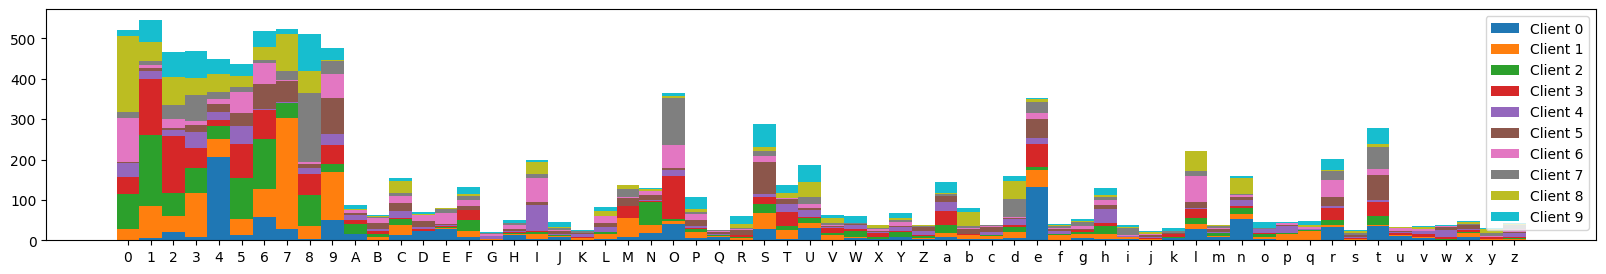

In [9]:
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True,
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(62), mapp)
plt.legend()
plt.show()

 We now instantiate a population of 10 clients and define the PS server. The clients use an SGD optimizer with a learning rate $\eta=0.1$.

In [10]:
for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = None
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

In [11]:
# for client in [clients[0], clients[5]]:
#     print("Client {}:".format(client.id))
#     i = 0
#     plt.figure(figsize=(15, 1))
#     for data in iter(client.train_loader.dataset):
#         x, y = data
#         plt.subplot(1, 10, i+1)
#         plt.imshow(x.numpy().T, cmap="Greys")
#         plt.title("Label: {}".format(mapp[y]))
#         plt.show()
#         if i == 9 or i == len(client.train_loader.dataset) - 1:
#             break
#         else:
#             i += 1

Client 0:


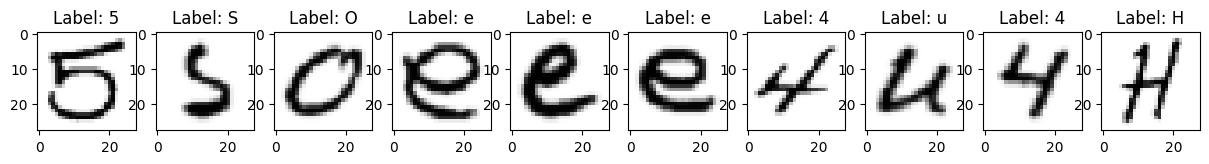

Client 5:


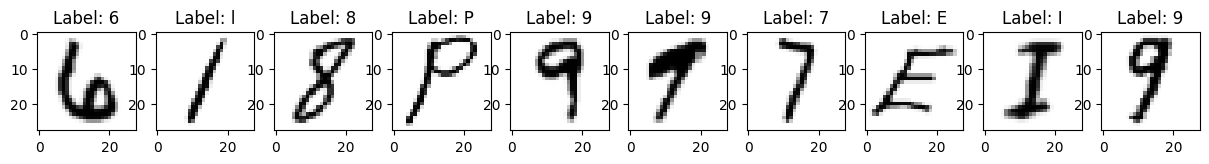

In [12]:
for client in [clients[0], clients[5]]:
    print("Client {}:".format(client.id))
    images = []
    labels = []
    for i, data in enumerate(client.train_loader.dataset):
        x, y = data
        images.append(x.numpy().T)
        labels.append(y)
        if i == 9:
            break
    
    # Plot all images in a single row
    plt.figure(figsize=(15, 1.5))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, 10, i+1)
        plt.imshow(img, cmap="Greys")
        plt.title("Label: {}".format(mapp[label]))
        # plt.axis('off')
    plt.show()


Everything is set up to the Federated Learning algorithm.

During training, we track the mean and std client accuracies, as well as the average and maximum client update norms. These two metrics allow us to measure the level of heterogeneity within the population of devices. When the average client update is small, it means that the FL procedure is close to a stationary point; however, if the maximum client update norm remains large, this means that there exist clients that have not converged locally.


**EXERCISE TODO: Using the methods above, define the training round of the FL procedure. In particular, sample a fraction of population of devices, compute the weights updates for each participating devices and aggregate the weights updates.**

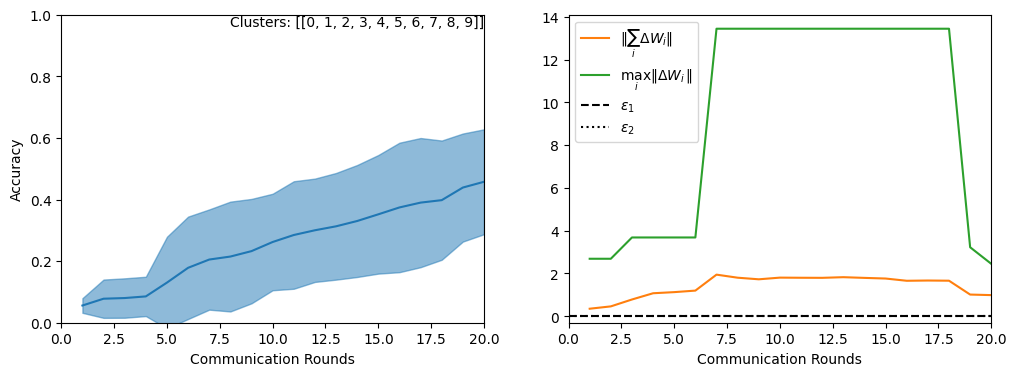

In [13]:
COMMUNICATION_ROUNDS = 20 # Increased from 2 to 20

cfl_stats = ExperimentLogger()

cluster_indices = [np.arange(len(clients)).astype("int")]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
    ## TODO: Sample the participating clients
    ## Your code here

    participating_clients = server.select_clients(clients, frac=0.2) # Added

    for client in participating_clients:
        ## TODO: Compute the update for each participating clients
        ## Your code here

        client.compute_weight_update(epochs=1) ## Added

        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

    ## TODO: Aggregate the updates for each participating clients
    ## Your code here

    server.aggregate_weight_updates(participating_clients) ## Added

    acc_clients = [client.evaluate() for client in clients]

    cfl_stats.log({"acc_clients" : acc_clients,
                   "mean_norm" : mean_norm,
                   "max_norm" : max_norm,
                   "rounds" : c_round,
                   "clusters" : cluster_indices})


    display_train_stats(cfl_stats, 0, 0, COMMUNICATION_ROUNDS)

for idc in cluster_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

Even if the FL procedure converges (plateau on the left plot) and the mean model update $\lVert\sum_i\Delta W_i\lVert$ converges to zero, there exist clients with large model updates $\max_i\lVert\Delta W_i\lVert$. This indicates that there exists some degree of model heterogeneity.

We now compute the local performance on each client of the trained model.

In [14]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [15]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i)
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.291262,0.558052,0.712500,0.620253,0.263158,0.441176,0.289017,0.220339,0.627358,0.553191


As we can see, the performance are heterogeneous and with average performance $\sim 78\%$. The difference between the best and the worst performing client is $\sim 10\%$

# Federated Learning with Label Shift and Covariate Shift

Now, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [16]:
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

In [17]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

Client 0:


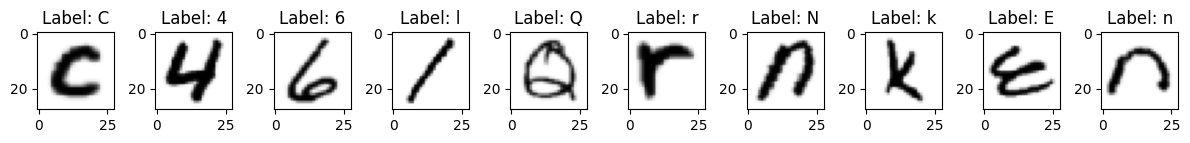

Client 5:


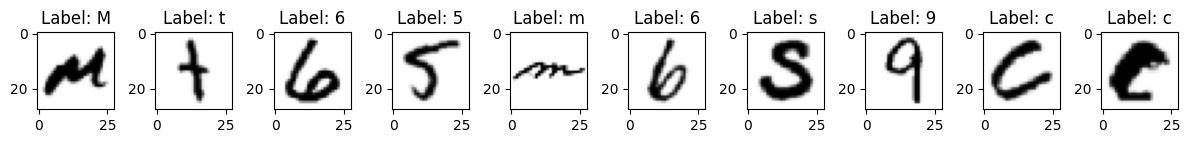

In [18]:
for client in [clients[0], clients[5]]:
    x, y = next(iter(client.train_loader))
    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

We run again the same FL procedure using this new data distribution

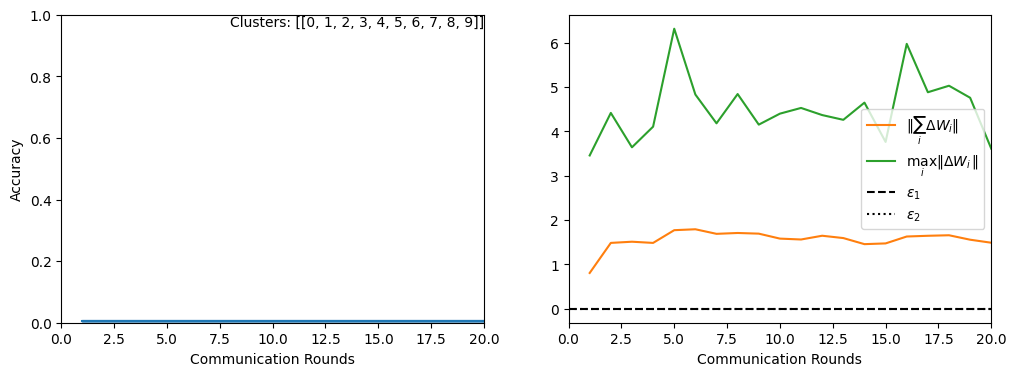

In [19]:
COMMUNICATION_ROUNDS = 20 # Increased from 2 to 20


cfl_stats = ExperimentLogger()

cluster_indices = [np.arange(len(clients)).astype("int")]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)

    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

    # Correct aggregation of updates
    updates = [client.dW for client in participating_clients]
    aggregated_update = {}
    for key in updates[0].keys():
        aggregated_update[key] = sum(update[key] for update in updates) / len(updates)
    # server.aggregate_weight_updates(participating_clients)

    acc_clients = [client.evaluate() for client in clients]

    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})


    display_train_stats(cfl_stats, 0,0, COMMUNICATION_ROUNDS)


for idc in cluster_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

We can see that compared to the previous scenario, the performance greatly degrades ($\sim 15\%$). As expected, we record an even larger mismatch between the magnitude of the mean update magnitude and the maximum update magnitude.

In [20]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [21]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i)
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.009709,0.000000,0.004167,0.004219,0.007519,0.011765,0.000000,0.011299,0.009434,0.005319


The performance among different users remains heterogenous and in general lower than the previous case.

# Part 2: Clustered Federated Learning

In the second part of the lab, we try to compensate for data heterogeneity using the Clustered FL algorithm proposed by Felix Sattler et al. (https://arxiv.org/abs/1910.01991)

Clustered federated learning is a variant of the standard FL, in which similarity between clients updates is tracked during training and used to branch the FL procedure in independent streams each with a cluster of homogeneous users.

Clustered FL employs the cosine score to measure similarity between users, namely given model $W_i\in\mathbb{R}^d$ and $W_j\in\mathbb{R}^d$, the cosine similarity is given by

$$\cos_s(W_i,W_j)=\frac{W_i\cdot W_j}{\lVert W_i\lVert\lVert W_j\lVert}$$

**EXERCISE TO DO: implement the cosine similarity primitive between a list of source models**

In [22]:
# def flatten(model):
#     """
#     Flatten the model parameters into a single vector.
#     """
#     return torch.cat([param.view(-1) for param in model.parameters()])

# Function to flatten a dictionary of tensors
def flatten(dW):
    """
    Flatten the dictionary of model parameters into a single vector.
    """
    return torch.cat([param.view(-1) for param in dW.values()])


In [23]:
def pairwise_angles(sources):
    ## TODO: Implement the pairwise_angle function given by the following formula
    num_sources = len(sources)
    angles = torch.zeros((num_sources, num_sources))

    for i, source1 in enumerate(sources):
        s1 = flatten(source1)
        norm_s1 = torch.norm(s1)
        
        for j, source2 in enumerate(sources):
            ## TODO: Compute the cosine similarity score between the model param vectors s1 and s2
            ## Your code here
            if i == j:
                angles[i, j] = 1.0
            else:
                s2 = flatten(source2)
                norm_s2 = torch.norm(s2)
                
                # Compute the cosine similarity score
                cosine_similarity = torch.dot(s1, s2) / (norm_s1 * norm_s2)
                angles[i, j] = cosine_similarity

    return angles.numpy()

In the Clustered FL procedure, the parameter server, in addition to aggregating model estimates, also tracks similarity between users and cluster them based on their instantaneous similarity scores. Accordingly the Server class comprises three new methods:
1. compute_pairwise_similarities that computes the similarity scores between the model updates returned by the FL users.
2. cluster_clients that clusters the FL clients based on their similarity scores.
3. aggregate_clusterwise, the modified aggregation rule that averages the model updates based on the current clustering


In [24]:
class Server(object):
    def __init__(self, model_fn, data):
        self.model = model_fn().to(device)
        self.data = data
        self.W = {key: value for key, value in self.model.named_parameters()}
        self.loader = DataLoader(self.data, batch_size=128, shuffle=False)
        self.model_cache = []

    def select_clients(self, clients, frac=1.0):
        return random.sample(clients, int(len(clients)*frac))

    def aggregate_weight_updates(self, clients):
        # EXERCISE: Implement the federated averaging rule
        reduce_add_average(target=self.W, sources=[client.dW for client in clients])

    def compute_pairwise_similarities(self, clients):
        return pairwise_angles([client.dW for client in clients])

    def cluster_clients(self, S):
        clustering = AgglomerativeClustering(affinity="precomputed", linkage="complete").fit(-S)

        c1 = np.argwhere(clustering.labels_ == 0).flatten()
        c2 = np.argwhere(clustering.labels_ == 1).flatten()
        return c1, c2

    def aggregate_clusterwise(self, client_clusters):
        for cluster in client_clusters:
            reduce_add_average(targets=[client.W for client in cluster],
                               sources=[client.dW for client in cluster])

    def compute_max_update_norm(self, cluster):
        return np.max([torch.norm(flatten(client.dW)).item() for client in cluster])

    def compute_mean_update_norm(self, cluster):
        return torch.norm(torch.mean(torch.stack([flatten(client.dW) for client in cluster]), dim=0)).item()

    def cache_model(self, idcs, params, accuracies):
        self.model_cache += [(idcs,
                            {name : params[name].data.clone() for name in params},
                            [accuracies[i] for i in idcs])]

    def evaluate(self, loader=None):
        return eval_op(self.model, self.eval_loader if not loader else loader)

We are now ready to run the Clustered FL procedure. In particular, the procedure works iteratively as the standard FL procedure, but at every round it measures the pairwise similarity. If the procedure converges $\lVert\sum_i\Delta W_i\lVert \leq \epsilon_1$ and there exist clients with large model updates $\max_i\lVert\Delta W_i\lVert >\epsilon_2$, then it performs clustering of the users based on their similarity.

**EXERCISE TODO: define the condition so as to perform clustering of the clients.**

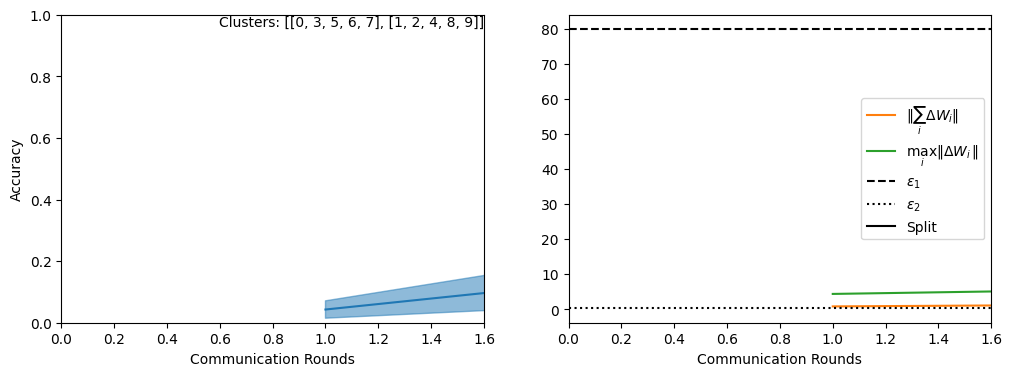

In [25]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

COMMUNICATION_ROUNDS = 80
EPS_1 = 0.4
EPS_2 = 1.6


cfl_stats = ExperimentLogger()

cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)

    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        ## TODO: Define the condition for the clustering to take place
        ## Your code here

         # Clustering condition
        if mean_norm < EPS_1 and max_norm > EPS_2 and len(idc) > 2 and c_round > 20:
            server.cache_model(idc, clients[idc[0]].W, acc_clients)

            c1, c2 = server.cluster_clients(similarities[idc][:,idc])
            cluster_indices_new += [c1, c2]

            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]


    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]

    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})


    display_train_stats(cfl_stats,COMMUNICATION_ROUNDS, EPS_1, EPS_2)


for idc in cluster_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

Around Round 30, Clustered FL splits the group of 10 users into two smaller groups of 5 users, each corresponding to the different rotation of the E-MNIST images.

In [26]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i)
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.776699,0.782772,0.825000,0.776371,0.676692,0.747059,0.664740,0.768362,0.750000,0.750000
Model 0,0.800971,0.000000,0.000000,0.717300,0.000000,0.758824,0.687861,0.774011,0.000000,0.000000
Model 1,0.000000,0.794007,0.791667,0.000000,0.744361,0.000000,0.000000,0.000000,0.773585,0.760638


At the end of training there exist two models (one for each cluster) and as we can see, each model is personalized for the different rotation of the E-MNIST samples.

**EXERCISE TODO: Compare the performance with the previous procedure without clustering.**